# Gate detection pipeline
  1. crop/manipulate images (tbd)
  2. preprocess
    * filter out blue
      * max 255 - 50 for red and yellow
      * filter out blue - leave some no more than 100 test
    * apply threshold
    * find contours
    * calculate/find gate/bars (the more the better)
    * get features from HOG
  3. classification
    * feed boxed images to SVM
    * use non gate images to test classifier

### 1. crop/manpulate images

In [268]:
## work-in-prograss

### 2. preprocess

In [269]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

*useful functions*

In [270]:

def resize(img, scale): # resize image to scale value param
    return cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale) ) )


def scaled(img, scale): # returns new scale value
    img_shape_x, img_shape_y, channels = img.shape
    if img_shape_x > scale:
        return scale / img_shape_x
    else:
        return 1
    

def preprocess(image, lower_upper_list): # 2nd param now takes a list to handle python3
    lower = np.array(lower_upper_list[0], dtype="uint8")
    upper = np.array(lower_upper_list[1], dtype="uint8")
    
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    
    return output, mask


*sample images/video path*

In [271]:
img2_path = "../img-to-video/third_run/front09.jpg" # had to get a little creative to find this
img1_path = "../img-to-video/fourth_run/front55.jpg" # gate detection was easier - all 3 bars

#vid1_path = "../img-to-video/run3.avi"
#vid2_path = "../img-to-video/run4.avi"


*import images*

In [259]:
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
print("image 1 shape:", img1.shape )
print("image 2 shape:", img2.shape )

#vid1 = cv2.Video

image 1 shape: (480, 744, 3)
image 2 shape: (480, 744, 3)


*show both images*

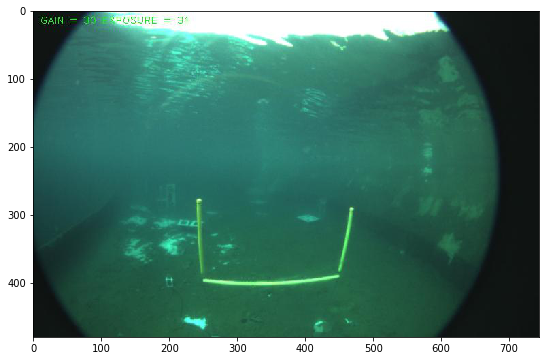

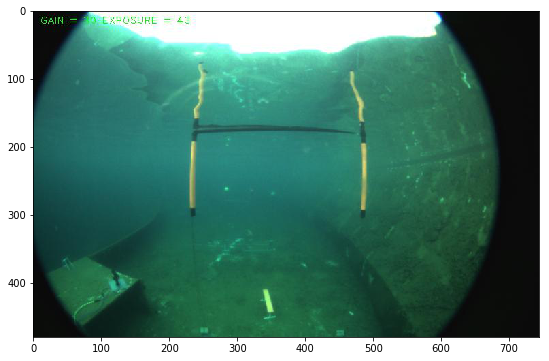

In [260]:
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) )
plt.show()

plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) )
plt.show()

###  *filter out blues*

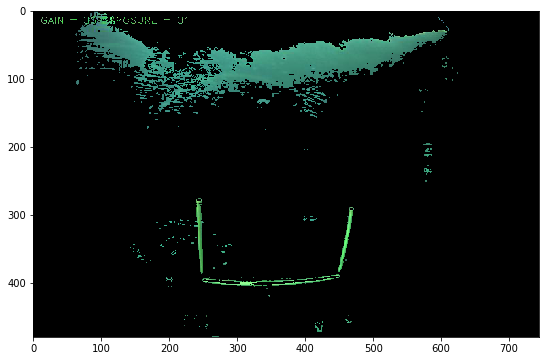

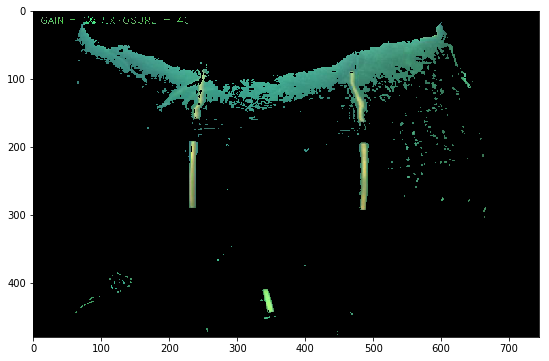

In [261]:
#lower_blue = np.array([0, 0, 0]) # good result values
lower_blue = np.array([55, 55, 55]) # for testing

#upper_blue = np.array([130, 255, 255]) # good result values
upper_blue = np.array([150, 255, 255]) # for testing

pimage1, mask = preprocess(img1, [ lower_blue, upper_blue ])
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(pimage1, cv2.COLOR_BGR2RGB) )
plt.show()

pimage2, mask = preprocess(img2, [ lower_blue, upper_blue ])
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(pimage2, cv2.COLOR_BGR2RGB) )
plt.show()

*to grayscale*

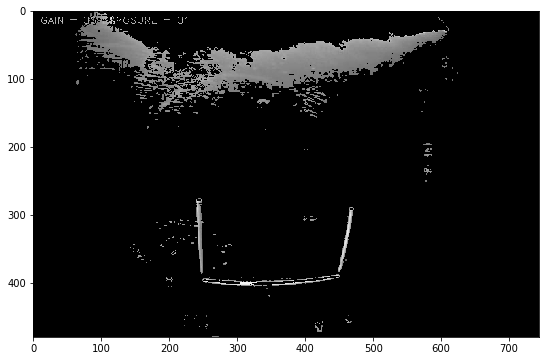

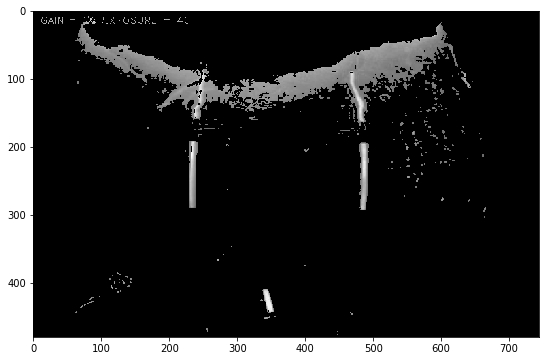

In [262]:
img1_gray = cv2.cvtColor(pimage1, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 6) )
plt.imshow(img1_gray, cmap='gray')
plt.show()

img2_gray = cv2.cvtColor(pimage2, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 6) )
plt.imshow(img2_gray, cmap='gray')
plt.show()

### *apply threshold*

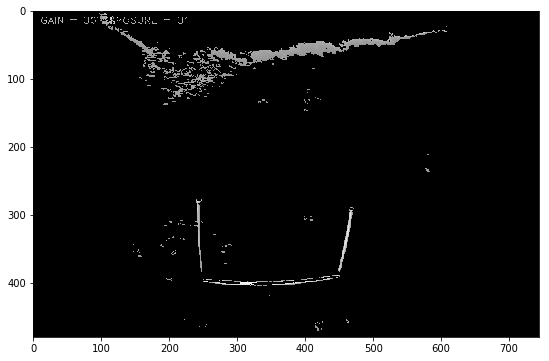

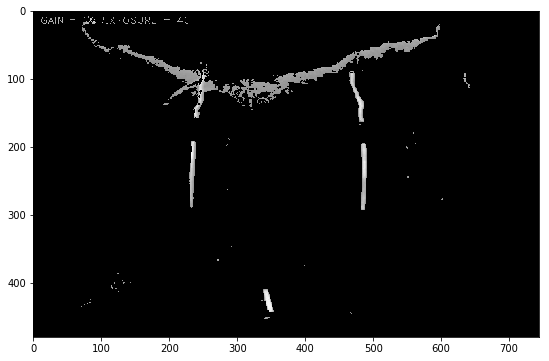

In [263]:
#ret1, img1_thresh = cv2.threshold(img1_gray, 127, 255, 0 )
ret1, img1_thresh = cv2.threshold(img1_gray, 127, 255, cv2.THRESH_TOZERO )

#ret2, img2_thresh = cv2.threshold(img2_gray, 127, 255, 0 )
ret2, img2_thresh = cv2.threshold(img2_gray, 127, 255, cv2.THRESH_TOZERO )

plt.figure(figsize=(10, 6) )
plt.imshow(img1_thresh, cmap='gray')
plt.show()

plt.figure(figsize=(10, 6) )
plt.imshow(img2_thresh, cmap='gray')
plt.show()

### *find contours*

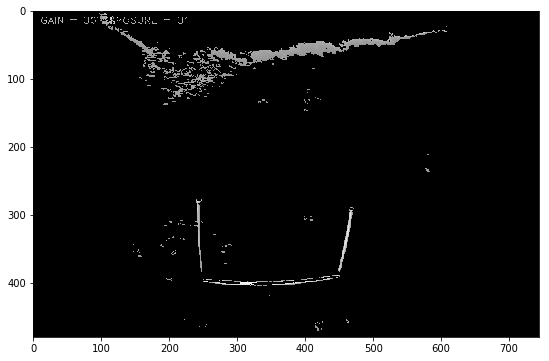

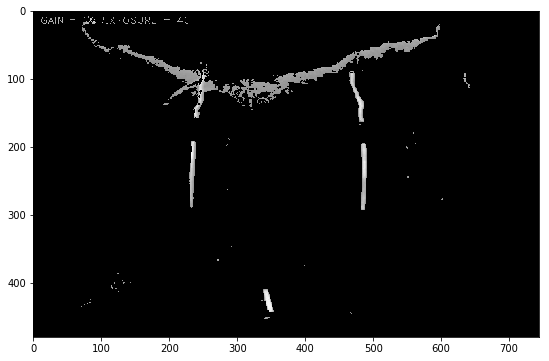

In [264]:
img1_c, img1_contours, img1_heirarchy = cv2.findContours(img1_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img2_c, img2_contours, img2_heirarchy = cv2.findContours(img2_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.figure(figsize=(10, 6) )
plt.imshow(img1_c, cmap='gray')
plt.show()

plt.figure(figsize=(10, 6) )
plt.imshow(img2_c, cmap='gray')
plt.show()

*draw contours*

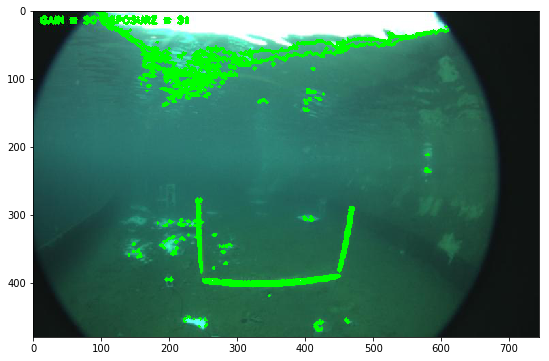

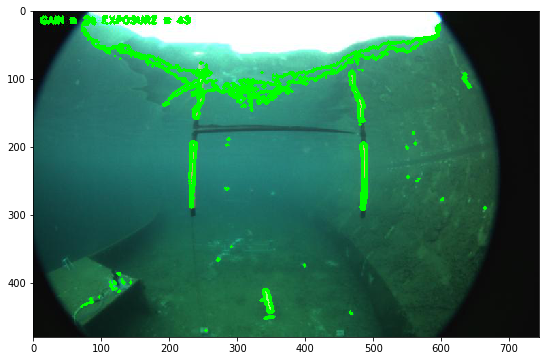

In [265]:
threshold_color = [0, 255, 0] # green

img1_copy = img1.copy()

cv2.drawContours(img1_copy, img1_contours, -1, threshold_color, 3)
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(img1_copy, cv2.COLOR_BGR2RGB) )
plt.show()


img2_copy = img2.copy()

cv2.drawContours(img2_copy, img2_contours, -1, threshold_color, 3)
plt.figure(figsize=(10, 6) )
plt.imshow(cv2.cvtColor(img2_copy, cv2.COLOR_BGR2RGB) )
plt.show()

*useful bounding box functions*

In [266]:
def create_all_boxes(img_contours_list): # takes in a list of contour coordinates and returns an list of boxes around contours
    box_list = []
    for contour in img_contours_list:
        cv2.boundingRect(contour)
        box_list.append(contour)
    return box_list

def filter_boxes(img_rectangle_list, filter_size=0):
    filtered_boxes = []
    for rectangle in img_rectangle_list:
        if(rectangle[2] * rectangle[3] > filter_size):
            filtered_boxes.append(rectangle)
    return filtered_boxes

def draw_rectangles(img, img_rectangle_list, x_offset=0, y_offset=0):
    for x, y, w, h in img_rectangle_list:
        cv2.rectangle(
            img,
            (x - x_offset, y - y_offset),
            ( (x + x_offset) + w, (y + y_offset) + h),
            (0, 255, 0),
            2
        )

### *calculate/find gate/bars (the more the better)*

In [267]:
cpy1 = img1.copy()
rgb1 = rgb1 = cv2.cvtColor(cpy1, cv2.COLOR_BGR2RGB)

img1_all_boxes = [cv2.boundingRect(c) for c in img1_contours]
#img1_all_boxes = create_all_boxes(img1_contours) # doesn't work... idk why
print("Image 1 number of boxes:", len(img1_all_boxes) )

box_filter_size = 400
img1_filter_boxes = filter_boxes(img1_all_boxes, box_filter_size)
print("Image 1 number of filtered boxes over size", box_filter_size, ":", len(img1_filter_boxes) )




cpy2 = img2.copy()
rgb2 = rgb2 = cv2.cvtColor(cpy2, cv2.COLOR_BGR2RGB)

img2_all_boxes = [cv2.boundingRect(c) for c in img2_contours]
#img2_all_boxes = create_all_boxes(img2_contours) # doesn't work... idk why
print("Image 2 number of boxes:", len(img2_all_boxes) )

img2_filter_boxes = filter_boxes(img2_all_boxes, box_filter_size)
print("Image 2 number of filtered boxes over size", box_filter_size, ":", len(img2_filter_boxes) )



Image 1 number of boxes: 325
Image 1 number of filtered boxes over size 400 : 10
Image 2 number of boxes: 169
Image 2 number of filtered boxes over size 400 : 8


*draw boxes on images*

In [ ]:
draw_rectangles(rgb1, img1_filter_boxes, 5, 5)

plt.figure(figsize=(10, 6) )
plt.imshow(rgb1)
plt.show()

draw_rectangles(rgb2, img2_filter_boxes, 5, 5)

plt.figure(figsize=(10, 6) )
plt.imshow(rgb2)
plt.show()

### 3. classification